Varun Krishnan and Robert Lin
# Introduction:

##  Abstract:
Project Title: **Graphnet for Disease Spread** 


This notebook and the accompanying code demonstrates our model for understanding the flow of the spread of a disease.  We use a slightly modified SIR Model to generate simulated disease spreads, and then we try to learn this information using two different methods.  First, we use Google Deepmind's recently released Graph Nets library, which has the capacity to store (and dynamically update) disease capabilities such as its infectivity rate, transition power between edges, and the number of sick (and healthy) people in different nodes of the graph. We then compare the results of this simulation to a regular Feed-Forward Neural Network, and show that using Graphnets to store more data results in significantly better train and test accuracy - with the mean squared error being 3 times using Graphnet than with a regular Neural Network.


## Structure of this Notebook
This Notebook is structured as follows.

First, we provide an introduction to the model intuiton and various imports.
Next, we provide an in-depth breakdown of the structure of the model, in five  different parts - generating simulations, visualization, data generation,  model running, and a comparison to a regular neural network

Finally, we provide a means to easily run the code, for a user with limited time, and graphs showing model results from our runs.



# Imports



In [ ]:

import tensorflow as tf
import numpy as np
from random import randint

from graph_nets import modules
import sonnet as snt
from graph_nets import blocks
from graph_nets import utils_tf

import pandas as pd

from graph_nets import blocks
from graph_nets import graphs
from graph_nets import modules
from graph_nets import utils_np
from graph_nets import utils_tf

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import sonnet as snt
import tensorflow as tf



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [ ]:
## Generate Simulation

# Part 1: Generating a Simulation

## Initialize Variables Corresponding to a Simulation

In [ ]:

#graph_dicts = []

# The number of nodes (i.e cities) in the model
NODE_SIZE = 3

# The number of globals the model can accomodate (This number should be >= the number of globals that are passed).
GLOBAL_SIZE = 2

# The number of edges. This is proportional to the (Node Size) squared.
EDGE_SIZE = NODE_SIZE*NODE_SIZE

# The Minimum and Maximum population corresponding to a node.
#Populations will be randomly generated in the range [Min_Population, Max_Population]
MIN_POPULATION = 5000000
MAX_POPULATION = 10000000

# The maximum distance between two nodes. 
# Distances will be randomly generated in the range [Min_Population, Max_Population]
MAX_DISTANCE = 1000


#healthy_data = []
#last_index 


## Determine Initial Data and Graph Structure

In [ ]:
# Code to Dynamically Generate Graphs given a simulation.

## Takes in two arrays: An array of Populations, and an array of distances from the previous part o
def get_edge_weights(populations, distances):
  senders = []
  receivers = []
  edges = []
  ctr = 0
  edge_weights = np.zeros((NODE_SIZE,NODE_SIZE))
  # Assume that the edge weight formula is some combination of Population, specific edgeweight
  for k in range(len(populations)):
    for l in range(len(populations)):
      distance = distances[ctr]
      senders.append(k)
      receivers.append(l)
      population_1 = populations[k]
      population_2 = populations[l]
      weight = (population_1 + population_2)/(2 * MAX_POPULATION) * distances[ctr] / (MAX_DISTANCE * NODE_SIZE)
      edges.append(weight)
      edge_weights[k][l] = weight
      ctr = ctr + 1
  # return senders, receivers, edges, edge_weights
  return senders, receivers, edges, edge_weights
       
# This involves only getting data for timestep 1 - and predicting the rest. 
def get_initial_data():
  sick_values = np.random.randint(500,1000, size = NODE_SIZE).astype(np.float32)
  populations = np.random.randint(MIN_POPULATION,MAX_POPULATION, size = NODE_SIZE).astype(np.float32)
  #print(EDGE_SIZE)
  distances = np.random.randint(MAX_DISTANCE, size = EDGE_SIZE).astype(np.float32)
  #print(len(distances))
  senders, receivers, edges,edge_weights = get_edge_weights(populations, distances)
  return sick_values, populations, senders, receivers, edges, edge_weights


## Run SIR Model



In [ ]:
def GenerateSimulated_Data(populations,nodes, edge_weights, infectivity_constant, num_sims):
  # Part 1: Transport Model:
  output_array = np.zeros((num_sims,NODE_SIZE))
  output_array[0] = nodes
  for sim in range(1,num_sims):
    new_nodes_list = []
    # total population should also be changing
    for k in range(len(nodes)):
      sum = 0
      row_edge_weight = edge_weights[k]
      outflow = 0
      inflow = 0
      for l in range(len(nodes)):
        
        # Part 1: Transport of People
        #print((row_edge_weight[k]-row_edge_weight[l]) * nodes[l])
        outflow = edge_weights[l][k]
        inflow = edge_weights[k][l]
        sum = sum + nodes[l] * inflow - nodes[k] * outflow
        #sum = sum + (row_edge_weight[l] ) * nodes[l]
      new_value = nodes[k] + sum
      
      # need to also transport people from one city to another
      # assume only sick people move about, but healthy people stay put
      
      #print(new_value)
      
      # Part 2: Transmission
      total_population = populations[k]
      if(nodes[k] >= total_population):
        sick_people = total_population
      else:
        sick_people = new_value +  infectivity_constant * nodes[k] * (total_population - nodes[k])
      output_array[sim][k] = sick_people
      new_nodes_list.append(sick_people)
    nodes = new_nodes_list 
    #edge_weight_sum = np.sum(edge_weights[k])
    
    # Mathematica Simulation Code: Do[healthy[[i]] = (1 - Total[weights[[i]]])* healthy[[i]] + (weights.healthy)[[i]]; , {i, 1, n}]; 
        #print(output_array[sim][k])
          #healthy[[i]] = (1 - Total[weights[[i]]])* healthy[[i]] + (weights.healthy)[[i]]
  # returns the sick people at each node
  return output_array

## Generate a Graph Data Dictionary, in the format required for GraphNet)


In [ ]:

def get_test_graph_data_dicts(infect_constant, sick, pops, edges, senders, receivers ):
  return {      
   "globals": np.array([infect_constant]).T.astype(np.float32),
   #"globals": np.random.rand(num_edges).T.astype(np.float32), 
   "nodes": np.array([sick, pops]).T.astype(np.float32),
   #"edges": np.random.rand(num_edges, EDGE_SIZE).astype(np.float32),
     
   "edges":  np.array([edges]).T.astype(np.float32),
   "senders": senders,
   "receivers": receivers,
  }


# Part 2: Generating Data

## Generating Training Data

This generates training data in 80 batches, each with 100 simulations.

In [ ]:
graphdict_training_batch=[]
batch_size = 80
infectivity_constant = .00000001
num_sims = 100
output_array_list = []
for b in range(batch_size):
    sick_values, populations, senders, receivers, edges,edge_weights  = get_initial_data()  # get initial data once
    output_array = GenerateSimulated_Data(populations,sick_values, edge_weights, infectivity_constant, num_sims)  
    output_array_list.append(output_array)
    graphdicts1 = []
    for sick in output_array:
      graphdicts1.append(get_test_graph_data_dicts(infectivity_constant, sick, populations, edges, senders, receivers ))
    graphdict_training_batch.append(graphdicts1)

## Generating Testing Data
This generates training data in 20 batches, each with 100 simulations.

In [ ]:
graphdict_test_batch=[]
batch_size = 20
infectivity_constant = .00000001
num_sims = 100

for b in range(batch_size):
    sick_values, populations, senders, receivers, edges,edge_weights  = get_initial_data()  # get initial data once
    output_array = GenerateSimulated_Data(populations,sick_values, edge_weights, infectivity_constant, num_sims)   
    graphdicts1 = []
    for sick in output_array:
      graphdicts1.append(get_test_graph_data_dicts(infectivity_constant, sick, populations, edges, senders, receivers ))
    graphdict_test_batch.append(graphdicts1)

## Understanding Memory Allocation

In [ ]:
import sys
def get_size(obj, seen=None):
    """Recursively finds size of objects"""
    size = sys.getsizeof(obj)
    if seen is None:
        seen = set()
    obj_id = id(obj)
    if obj_id in seen:
        return 0
    # Important mark as seen *before* entering recursion to gracefully handle
    # self-referential objects
    seen.add(obj_id)
    if isinstance(obj, dict):
        size += sum([get_size(v, seen) for v in obj.values()])
        size += sum([get_size(k, seen) for k in obj.keys()])
    elif hasattr(obj, '__dict__'):
        size += get_size(obj.__dict__, seen)
    elif hasattr(obj, '__iter__') and not isinstance(obj, (str, bytes, bytearray)):
        size += sum([get_size(i, seen) for i in obj])
    return size

In [ ]:
print("Size of Training Batch is " + str(get_size(graphdict_training_batch)))
print("Size of Testing Batch is " + str(get_size(graphdict_test_batch)))

Size of Training Batch is 64
Size of Testing Batch is 1275106


So 5 gigabytes of data for a single graphdict_training_batch!

*   List item
*   List item



## Process Training and Test Data

### Generate X_Train and Y_Train Data

In [ ]:
X_train = [graph[0:-1] for graph in graphdict_training_batch]
Y_train = [graph[1::] for graph in graphdict_training_batch]

### Flatten the Data

In [ ]:
import itertools

chain = itertools.chain(*X_train)
X_train_flatten = list(chain)

chain2 = itertools.chain(*Y_train)
Y_train_flatten = list(chain2)

In [ ]:
### Examining Memory of Flattened Data

In [ ]:
print("Flattened X_train size " + str(get_size(X_train_flatten)))
print("Flattened Y_train size " + str(get_size(Y_train_flatten)))

Flattened X_train size 64
Flattened Y_train size 64


### Example: What the Y_train Dataset looks like


In [ ]:
Y_train[5][5]

{'edges': array([[0.15382826],
        [0.06410106],
        [0.18548469],
        [0.02385638],
        [0.08369811],
        [0.17857394],
        [0.14211732],
        [0.10078529],
        [0.03713388]], dtype=float32),
 'globals': array([1.e-08], dtype=float32),
 'nodes': array([[1.205399e+03, 5.856406e+06],
        [9.372083e+02, 6.590402e+06],
        [7.218490e+02, 5.407847e+06]], dtype=float32),
 'receivers': [0, 1, 2, 0, 1, 2, 0, 1, 2],
 'senders': [0, 0, 0, 1, 1, 1, 2, 2, 2]}

In [ ]:
X_train_flatten[0]

{'edges': array([[0.16273135],
        [0.16732875],
        [0.1813433 ],
        [0.19149554],
        [0.16710742],
        [0.1667305 ],
        [0.0408208 ],
        [0.0865716 ],
        [0.19877978]], dtype=float32),
 'globals': array([1.e-08], dtype=float32),
 'nodes': array([[7.610000e+02, 8.431676e+06],
        [5.180000e+02, 7.329273e+06],
        [5.080000e+02, 6.412251e+06]], dtype=float32),
 'receivers': [0, 1, 2, 0, 1, 2, 0, 1, 2],
 'senders': [0, 0, 0, 1, 1, 1, 2, 2, 2]}

# Part 3: Visualization

## Code to visualize graph results



In [ ]:
def plot_compare_graphs(graph_dicts):
  pos = None
  num_graphs = len(graph_dicts)
  _, axes = plt.subplots(1, num_graphs, figsize=(11*num_graphs, 11))
  if num_graphs == 1:
    axes = axes,
  pos = None
  ctr = 0
  for graph_dict, ax in zip(graph_dicts, axes):
    graph_tuple =  utils_np.data_dicts_to_graphs_tuple([graph_dict])
    graph = utils_np.graphs_tuple_to_networkxs(graph_tuple)[0]
    pos = plot_graph_networkx(graph, ax, pos=pos)
    ax.set_title("Disease Visualization")
    ctr = ctr + 1
    
def plot_graphs_tuple_np(graphs_tuple):
  networkx_graphs = utils_np.graphs_tuple_to_networkxs(graphs_tuple)
  num_graphs = len(networkx_graphs)
  _, axes = plt.subplots(1, num_graphs, figsize=(11*num_graphs, 11))
  if num_graphs == 1:
    axes = axes,
  for graph, ax in zip(networkx_graphs, axes):
    plot_graph_networkx(graph, ax)


def plot_graph_networkx(graph, ax, pos=None):
  node_labels = {node: "{:.6g}".format(data["features"][0])
                 for node, data in graph.nodes(data=True)
                 if data["features"] is not None}
  edge_labels = {(sender,receiver): "{:.2g}".format(data["features"][0])
                 for sender,receiver, data in graph.edges(data=True)
                 if data["features"] is not None}
  global_label = ("Disease Value " + "{:.3g}".format(graph.graph["features"][0])
                  if graph.graph["features"] is not None else None)

  if pos is None:
    pos = nx.spring_layout(graph)
  for p in pos:  # raise text positions
    pos[p][1] += 5
  nx.draw_networkx(graph, pos, ax=ax, labels=node_labels,node_color = '#40E0D0',node_size = 2000,font_size = 12)

  if edge_labels:
    nx.draw_networkx_edge_labels(graph, pos, edge_labels, ax=ax)

  if global_label:
    plt.text(0.05, 0.95, global_label, transform=ax.transAxes)

  ax.yaxis.set_visible(False)
  ax.xaxis.set_visible(False)
  return pos

## Visualization 1: Timesteps 1 - 10

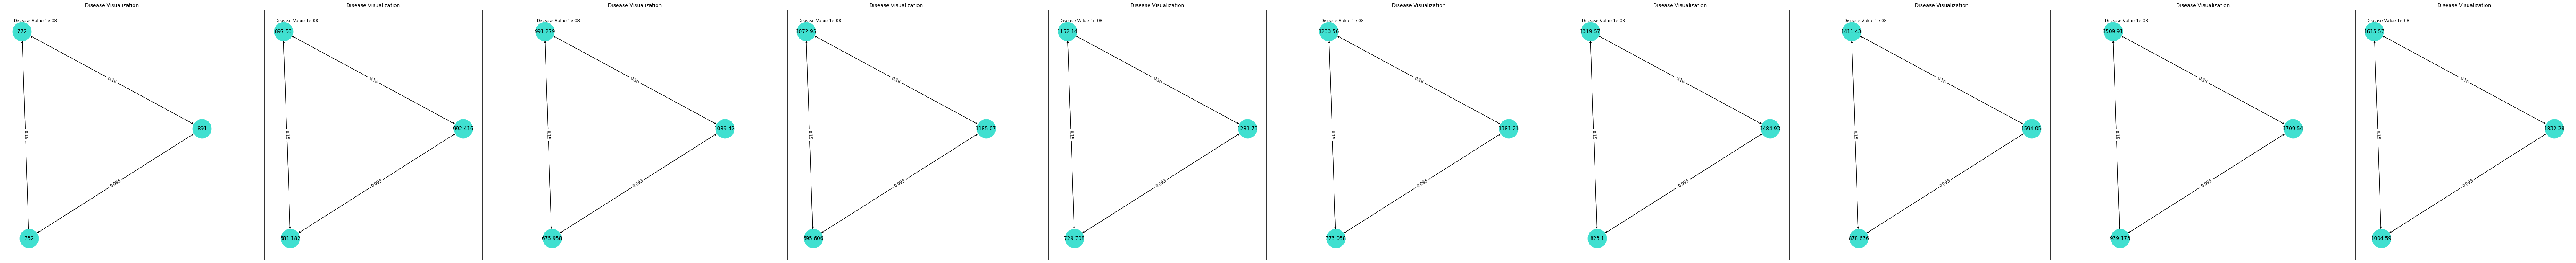

In [ ]:
plot_compare_graphs(graphdicts1[0:10])

## Visualization 2: Timesteps 90 - 100


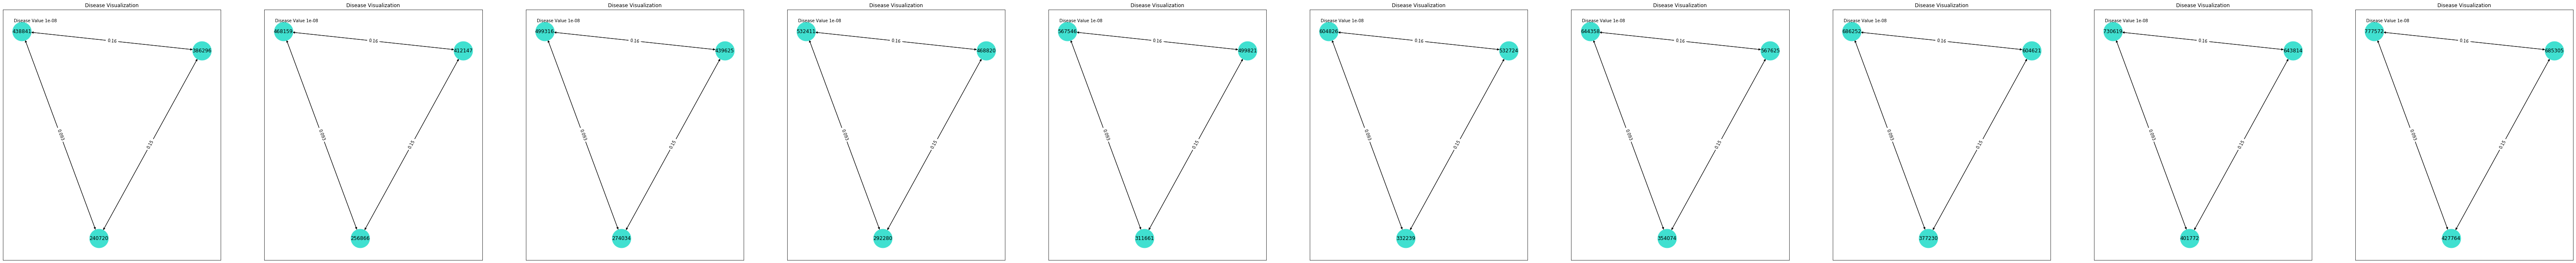

In [ ]:
plot_compare_graphs(graphdicts1[90:100])

# Part 4: Initializing and Running the Model

## Create a Loss Function

To train our neural network, we simply define a loss function which is the mean square error between node populations in the "target" and the "output" graph.

In [ ]:
def create_loss_ops(target_ops, output_ops):
  """Create supervised loss operations from targets and outputs.
  """
  loss_ops =  tf.reduce_mean(tf.square(tf.subtract(target_ops.nodes,output_ops.nodes)))
  return loss_ops

## Create a Neural Network

This neural network is the default graph neural network used in the "Physics" demo of Graph_Net.

In [ ]:
# Set up output_ops
tf.reset_default_graph()

OUTPUT_NODE_SIZE = 2 # node features (must be 2)
OUTPUT_EDGE_SIZE = EDGE_SIZE # irrelevant operator
OUTPUT_GLOBAL_SIZE = 1 # irrelevant operator
graph_network = modules.GraphNetwork(
    edge_model_fn=lambda: snt.Linear(output_size=OUTPUT_EDGE_SIZE),
    node_model_fn=lambda: snt.Linear(output_size=OUTPUT_NODE_SIZE),
    global_model_fn=lambda: snt.Linear(output_size=OUTPUT_GLOBAL_SIZE))

## Training Component

For our training, our training goal is to predict the dynamics of the disease spreading on our graph. To do so, we set-up a simple graph network which takes as input a graph and to output a graph.

The output graph corresponds to the same graph as the input, but after it has "evolved" for one time step.

###  Set up Computational Graphs for Input and Output of a Graph Network

In [ ]:
print("Size of training set is", len(X_train_flatten), "graphs")
input_graphs = utils_tf.data_dicts_to_graphs_tuple(X_train_flatten)
# make sure graph_network is initialized
output_graphs = graph_network(input_graphs)
target_graphs = utils_tf.data_dicts_to_graphs_tuple(Y_train_flatten)

Size of training set is 7920 graphs
Instructions for updating:
Colocations handled automatically by placer.


Very costly operation! Probably the most costly of all. This converts all the graph dicts into graph tuple objects, but it is a Tensor. So the computational graph is enormous. Hugely memory intensive.

This operation is not difficult. We will also set up the target graph via Tensorflow.

These are now tensors!

### Set up loss function computation via target graphs and output graphs. 

This is a delayed operation.

In [ ]:
# Training loss.
print("Here we pass in", len(X_train_flatten),"pairs of graphs to the loss function")
loss_ops_tr = create_loss_ops(target_graphs, output_graphs)
print("The loss function computes the mean square error of the node feature vectors.")

Here we pass in 7920 pairs of graphs to the loss function
The loss function computes the mean square error of the node feature vectors.


### Set up the optimizer, which takes in the loss Tensor, and minimizes it.

In [ ]:
# Optimizer.
# set the learning rate for Adam
# note: rmsprop is significantly worse
learning_rate = 5e-3
optimizer = tf.train.AdamOptimizer(learning_rate)
step_op = optimizer.minimize(loss_ops_tr)
#input_graph_tr = make_all_runnable_in_session(input_graph_tr)

### Now actually run everything in a TF session.

In [ ]:
try:
  sess.close()
except NameError:
  pass
sess = tf.Session()
# make sure to initialize the graph
sess.run(tf.global_variables_initializer())

In [ ]:
import time
start = time.time()
# set number of epochs here
n_steps = 2000
loss_history = []

for i in range(n_steps):
    sess.run(step_op)
    loss_history.append(sess.run(loss_ops_tr))
    # uncomment for intermediate loss
    #print("Step", i, " \t Loss\t", loss_history[i])
end = time.time()
print("Time to Run", n_steps, "Epochs: ",end - start, "s")

Time to Run 2000 Epochs:  207.17892932891846 s


In [ ]:
print("Loss (MSE) at End of Epoch ", n_steps, ":\t",loss_history[-1])

Loss (MSE) at End of Epoch  2000 :	 3977469.0


Training complete.

# Part 5: Testing and Prediction

## Preparing the Test Set

In [ ]:
X_test = [graph[0:-1] for graph in graphdict_test_batch]
Y_test = [graph[1::] for graph in graphdict_test_batch]
print("Length of Test Batch: " + str(len(X_test)))

Length of Test Batch: 20


In [ ]:
import itertools

chain = itertools.chain(*X_test)
X_test_flatten = list(chain)

chain2 = itertools.chain(*Y_test)
Y_test_flatten = list(chain2)

print("Size of test set is", len(X_test_flatten), "graphs")
#Number of Graphs in Test Batch is len(X_test_flatten)

Size of test set is 1980 graphs


### Create Computational Graphs for Testing

In [ ]:
input_graphs_test=utils_tf.data_dicts_to_graphs_tuple(X_test_flatten)
# make sure graph_network is initialized
output_graphs_test = graph_network(input_graphs_test)

target_graphs_test = utils_tf.data_dicts_to_graphs_tuple(Y_test_flatten)

## Loss on Test Set

In [ ]:
test_loss =   create_loss_ops(target_graphs_test, output_graphs_test)
# make sure TF session is initialized
test_loss_ = sess.run(test_loss)
print("Loss (MSE) for Test Batch:", test_loss_)

Loss (MSE) for Test Batch: 2041758.1


In [ ]:
print("Ratio of Loss on Test to Training: ", test_loss_/loss_history[-1])

Ratio of Loss on Test to Training:  0.513331


## Predicting the 1-Step Dynamics using the Graph Net

The consistency of the test loss versus the training loss is reassuring. And it also makes sense that the loss is greater on the test set than on the training set.

But is this good enough? Are we actually capturing the underlying dynamics of disease spread using the graph network?

### Code for Generating Plots

In [ ]:
import matplotlib.pyplot as plt
output_graphs_test_ = sess.run(output_graphs_test)
input_graphs_test_ = sess.run(input_graphs_test)
target_graphs_test_ = sess.run(target_graphs_test)

sick_actual = target_graphs_test_[0][::,0]
healthy_actual = target_graphs_test_[0][::,1]
sick_predicted = output_graphs_test_[0][::,0]
healthy_predicted = target_graphs_test_[0][::,1]

Plotting the Relative Error

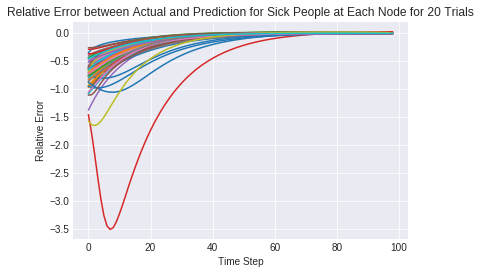

In [ ]:
#plt.plot(np.log10(sick_actual))
#plt.plot(np.log10(sick_predicted))
#plt.style.use('dark_background')
plt.style.use('seaborn-dark')
plt.subplot()
for i in range(NODE_SIZE):
  for j in range(20):
  # sample every 5 time steps
    plt.plot((sick_actual[i+99*NODE_SIZE*j:99*NODE_SIZE-1+99*NODE_SIZE*j:NODE_SIZE]-
           sick_predicted[i+99*NODE_SIZE*j:99*NODE_SIZE-1+99*NODE_SIZE*j:NODE_SIZE])/sick_actual[i+99*NODE_SIZE*j:99*NODE_SIZE-1+99*NODE_SIZE*j:NODE_SIZE],
             '-',
           label=str(i+1)+'th sick node actual-predicted for'+str(j)+'th run')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2,
#           frameon=True)
plt.xlabel("Time Step")
plt.ylabel("Relative Error")
plt.title("Relative Error between Actual and Prediction for Sick People at Each Node "+
          "for 20 Trials")
#plt.ylim([-1,0])
plt.grid()
plt.show()

Plotting the Side-By-Side Comparison

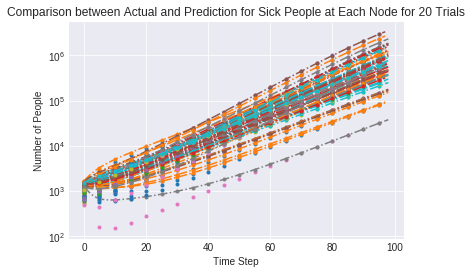

In [ ]:
#plt.plot(np.log10(sick_actual))
#plt.plot(np.log10(sick_predicted))
#plt.style.use('dark_background')
plt.style.use('seaborn-dark')
plt.subplot()
for i in range(NODE_SIZE):
  for j in range(20):
  # sample every 5 time steps
    plt.plot(sick_actual[i+99*NODE_SIZE*j:99*NODE_SIZE-1+99*NODE_SIZE*j:NODE_SIZE],
             '.', markevery =5)
    plt.plot(sick_predicted[i+99*NODE_SIZE*j:99*NODE_SIZE-1+99*NODE_SIZE*j:NODE_SIZE],'.-.',markevery=5)
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2,
#           frameon=True)
plt.yscale('log')
plt.xlabel("Time Step")
plt.ylabel("Number of People")
plt.title("Comparison between Actual and Prediction for Sick People at Each Node "+
          "for 20 Trials")
#plt.ylim([-1,0])
plt.grid()
plt.show()

Plotting the Raw Errors

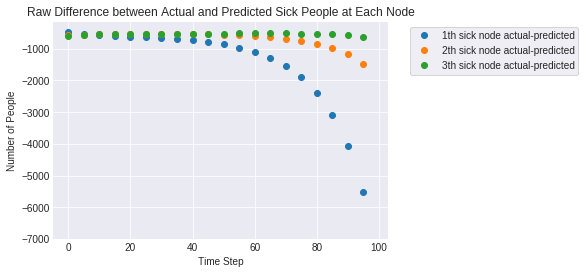

In [ ]:
#plt.plot(np.log10(sick_actual))
#plt.plot(np.log10(sick_predicted))
#plt.style.use('dark_background')
plt.style.use('seaborn-dark')
plt.subplot()
for i in range(NODE_SIZE):
  # sample every 5 time steps
  plt.plot(sick_actual[i:99*NODE_SIZE-1:NODE_SIZE]-
           sick_predicted[i:99*NODE_SIZE-1:NODE_SIZE],'o',
           label=str(i+1)+'th sick node actual-predicted',markevery=5)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2,
           frameon=True)
plt.xlabel("Time Step")
plt.ylabel("Number of People")
plt.title("Raw Difference between Actual and Predicted Sick People at Each Node")
plt.grid()
plt.show()

Plotting the Side-by-Side Comparison (SIngle Trial)

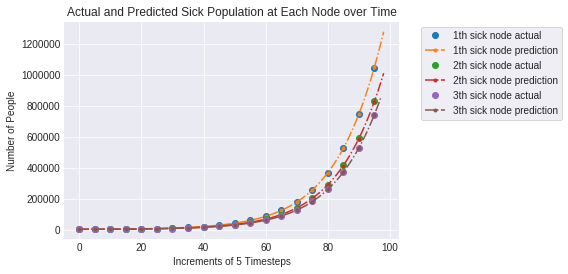

In [ ]:
#plt.plot(np.log10(sick_actual))
#plt.plot(np.log10(sick_predicted))
#plt.style.use('dark_background')
plt.style.use('seaborn-dark')
plt.subplot()
simu_num = 1
for i in range(NODE_SIZE):
  # sample every 5 time steps
  plt.plot(sick_actual[i+99*NODE_SIZE*simu_num:99*NODE_SIZE+99*NODE_SIZE*simu_num-1:NODE_SIZE],'o',
           label=str(i+1)+'th sick node actual',markevery=5)
  plt.plot(sick_predicted[i+99*NODE_SIZE*simu_num:99*NODE_SIZE+99*NODE_SIZE*simu_num-1:NODE_SIZE],'.-.',
           label=str(i+1)+'th sick node prediction',markevery=5)
  #plt.plot(healthy_actual[i:99*NODE_SIZE-1:NODE_SIZE*5],'o')
  #plt.plot(healthy_predicted[i:99*NODE_SIZE-1:NODE_SIZE*5],'.-.')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2,
           frameon=True)
plt.xlabel("Increments of 5 Timesteps")
plt.ylabel("Number of People")
plt.title("Actual and Predicted Sick Population at Each Node over Time")
plt.grid()
plt.show()

Plotting the Loss History

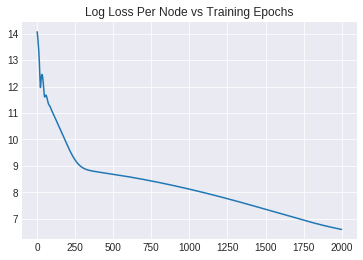

In [ ]:
plt.style.use('seaborn-dark')
plt.plot(np.log10(loss_history))
plt.title("Log Loss Per Node vs Training Epochs")
plt.grid()

NameError: ignored

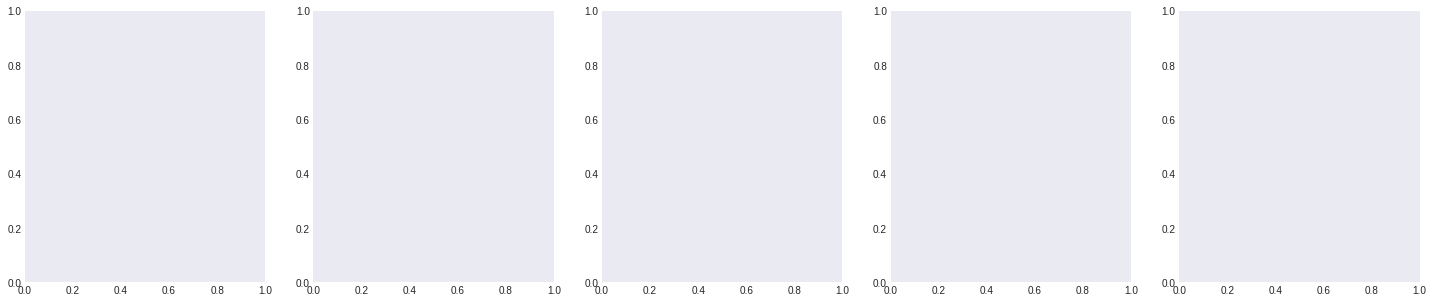

In [ ]:
  num_graphs = 5
  _, axes = plt.subplots(1, num_graphs, figsize=(5*num_graphs, 5))
  if num_graphs == 1:
    axes = axes,
  for graph, ax in zip(networkx_graphs, axes):
    plot_graph_networkx(graph, ax)

In [ ]:
networkx_output_graphs_test_ = utils_np.graphs_tuple_to_networkxs(output_graphs_test_)
  

In [ ]:
target_graphs_test_[0].shape

(5940, 2)

In [ ]:
output_graphs_test_[0].shape

(5940, 2)

So we have 5940 nodes with 2 features.

Pretty good!!

In [ ]:
#plt.plot(np.log10(healthy_actual))
#plt.plot(np.log10(healthy_predicted))

So, actually loss cannot be improved after 1500 steps.




#Add a regular neural network: Benchmarking against a Feedforward Neural Net

In [ ]:
xs = []
ys = []
for k in output_array_list:
  for l in range(len(k)-1):
    xs.append(k[l]) 
    ys.append(k[l+1])
print(len(xs))
print(len(ys))

7920
7920


In [ ]:
#from __future__ import print_function
from keras.optimizers import Adam
from keras.layers import Dense, Activation
from keras.models import Sequential
from sklearn import preprocessing
import numpy as np
from sklearn.model_selection import train_test_split
N = 1000
#XX_train = output_array_list[:80]
#XX_test = output_array_list[80:]
#XX_test = np.ones((N, 4)) * np.random.rand(N, 4) * 1000
XX_train, XX_test, YY_train_labels, YY_test_labels = train_test_split(xs,ys, test_size = 0.20)

#min_max_scaler = preprocessing.MinMaxScaler()
#min_max_scaler.fit(np.concatenate((XX_train, XX_test)))

#X_train_scale = min_max_scaler.transform(XX_train)
#X_test_scale = min_max_scaler.transform(XX_test)

model = Sequential()
model.add(Dense(input_dim=3, output_dim=500))
model.add(Activation('relu'))
model.add(Dense(input_dim=500, output_dim=3))
model.add(Activation('relu'))


model.compile(loss='mean_squared_error', optimizer='rmsprop')
#model.compile(optimizer=Adam(lr=0.01),loss='mean_squared_error')


#model.fit(np.array(XX_train), np.array(YY_train_labels),
#          batch_size=3, nb_epoch=100, verbose=2,
#          validation_data=(np.array(XX_test), np.array(YY_test_labels))
history = model.fit(np.array(XX_train), np.array(YY_train_labels),
          batch_size=100, nb_epoch=2000, verbose=0,
          validation_data=(np.array(XX_test), np.array(YY_test_labels)))
#model.fit(x, y, validation_split=0.25, epochs=50, batch_size=16, verbose=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=3, units=500)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=500, units=3)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


# Discussion and Conclusions

The graph net is expensive to run because it consumes around 4 GBs of RAM for just 3 nodes. So it is not very practical.



# Results

Here are the main results of our simulations.



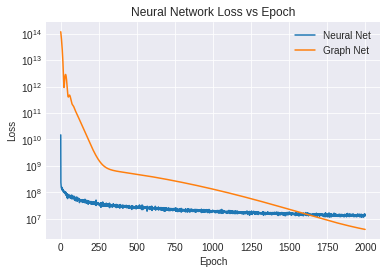

In [ ]:
plt.style.use('seaborn-dark')
plt.plot(history.history['loss'])
plt.plot(loss_history)
plt.title('Neural Network Loss vs Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.xlabel('Epoch')
plt.legend(['Neural Net', 'Graph Net'], loc='upper right')
plt.grid()
plt.show()